### Merging weather data with flying metrics

In [724]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from math import cos, radians, sin

pd.options.display.max_columns = 999
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [725]:
conn = psycopg2.connect("dbname = soaring_predictor")

### Loading flying metrics

In [726]:
F = pd.read_sql('SELECT * from flight_metrics;', conn)

In [727]:
# Isolating the best flight of the date (by max flying time)

Y = pd.DataFrame(F.groupby('date')['flying_time','max_alt','left_perimeter'].min())

In [728]:
F.columns

Index(['flight', 'date', 'pilot', 'launch_time', 'landing_time', 'flying_time',
       'launch_coord', 'landing_coord', 'landed_lz', 'linear_dist', 'max_alt',
       'total_alt_gain', 'left_perimeter', 'month', 'year', 'timestamp', 'doy',
       'rank_alt_0', 'rank_alt_1', 'rank_alt_2', 'overall_rank_0',
       'overall_rank_1', 'overall_rank_2', 'pilot_rank_0', 'pilot_rank_1',
       'pilot_rank_2'],
      dtype='object')

### Loading weather data

In [729]:
W = pd.read_sql('SELECT * from weather;', conn)

In [730]:
W.head()

,date,alti_0,alti_4,alti_8,alti_12,alti_16,alti_20,drct_0,drct_4,drct_8,drct_12,drct_16,drct_20,dwpf_0,dwpf_4,dwpf_8,dwpf_12,dwpf_16,dwpf_20,p01i_0,p01i_4,p01i_8,p01i_12,p01i_16,p01i_20,relh_0,relh_4,relh_8,relh_12,relh_16,relh_20,sknt_0,sknt_4,sknt_8,sknt_12,sknt_16,sknt_20,skyc1_0,skyc1_4,skyc1_8,skyc1_12,skyc1_16,skyc1_20,psgr_0,psgr_4,psgr_8,psgr_12,psgr_16,psgr_20,tmpf_0,tmpf_4,tmpf_8,tmpf_12,tmpf_16,tmpf_20,doy
0,2005-01-02,29.8825,29.9750,30.0400,30.0925,30.1525,30.1400,342.5,345.0,225.0,347.5,182.5,185.0,33.035,30.245,27.995,27.005,25.475,29.030,0.01,0.01,0.01,0.01,0.01000,0.0100,72.3325,68.0775,65.6925,70.2925,61.0250,60.370,9.50,6.50,6.25,8.75,9.25,9.25,0.9375,1.0,0.4375,0.0625,0.0000,0.000,0.1000,0.0925,0.0650,5.250000e-02,0.060,-0.0125,41.270,39.920,38.48,35.735,37.715,41.765,2
1,2005-01-03,30.1825,30.2225,30.2225,30.2150,30.2100,30.1625,360.0,180.0,350.0,2.5,182.5,350.0,27.500,26.240,26.510,24.800,26.510,27.050,0.01,0.01,0.01,0.01,0.01000,0.0100,66.9375,70.0600,79.1325,87.6325,74.9175,59.095,8.75,6.50,6.50,1.00,5.75,10.75,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0425,0.0400,0.0000,-7.500000e-03,-0.005,-0.0475,37.490,35.015,32.27,27.995,33.755,40.235,3
2,2005-01-04,30.1675,30.1750,30.1675,30.1675,30.1825,30.1350,105.0,350.0,267.5,102.5,227.5,275.0,23.810,23.540,25.025,22.460,22.190,21.245,0.01,0.01,0.01,0.01,0.01000,0.0100,62.1100,67.6400,73.5700,66.0400,57.5325,46.755,5.75,8.75,8.75,8.00,8.25,10.25,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0050,0.0075,-0.0075,3.552714e-15,0.015,-0.0475,35.510,33.080,32.54,32.540,35.735,40.010,4
3,2005-01-05,30.1450,30.1775,30.1875,30.2125,30.2825,30.2500,97.5,267.5,5.0,67.5,165.0,142.5,21.470,21.695,22.010,18.230,22.505,23.765,0.01,0.01,0.01,0.01,0.01000,0.0100,54.1350,63.4850,78.7200,77.3975,73.3375,54.695,4.50,6.00,0.75,1.75,4.50,3.25,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0100,0.0325,0.0100,2.500000e-02,0.070,-0.0325,36.500,32.765,27.77,24.305,30.245,38.705,5
4,2005-01-06,30.2275,30.2050,30.1425,30.0200,29.9000,29.7575,80.0,152.5,155.0,167.5,125.0,152.5,23.810,23.540,22.730,22.235,31.730,36.005,0.01,0.01,0.01,0.01,0.01125,0.0175,71.6350,81.4550,82.0125,74.0875,89.5300,87.290,2.00,3.75,4.75,5.00,4.25,5.75,0.0000,0.0,0.1875,0.6875,0.8125,0.375,-0.0225,-0.0225,-0.0625,-1.225000e-01,-0.120,-0.1425,31.955,28.490,27.50,29.480,34.520,39.470,6


In [731]:
def get_cos(direction):
    return (cos(radians(direction)))**2

In [732]:
direction = ['drct_0', 'drct_4', 'drct_8', 'drct_12', 'drct_16', 'drct_20']

for col in direction:
    W[col]=W[col].apply(get_cos)

In [770]:
W.head()

,date,alti_0,alti_4,alti_8,alti_12,alti_16,alti_20,drct_0,drct_4,drct_8,drct_12,drct_16,drct_20,dwpf_0,dwpf_4,dwpf_8,dwpf_12,dwpf_16,dwpf_20,p01i_0,p01i_4,p01i_8,p01i_12,p01i_16,p01i_20,relh_0,relh_4,relh_8,relh_12,relh_16,relh_20,sknt_0,sknt_4,sknt_8,sknt_12,sknt_16,sknt_20,skyc1_0,skyc1_4,skyc1_8,skyc1_12,skyc1_16,skyc1_20,psgr_0,psgr_4,psgr_8,psgr_12,psgr_16,psgr_20,tmpf_0,tmpf_4,tmpf_8,tmpf_12,tmpf_16,tmpf_20,doy
0,2005-01-02,29.8825,29.9750,30.0400,30.0925,30.1525,30.1400,0.909576,0.933013,0.500000,0.953154,0.998097,0.992404,33.035,30.245,27.995,27.005,25.475,29.030,0.01,0.01,0.01,0.01,0.01000,0.0100,72.3325,68.0775,65.6925,70.2925,61.0250,60.370,9.50,6.50,6.25,8.75,9.25,9.25,0.9375,1.0,0.4375,0.0625,0.0000,0.000,0.1000,0.0925,0.0650,5.250000e-02,0.060,-0.0125,41.270,39.920,38.48,35.735,37.715,41.765,2
1,2005-01-03,30.1825,30.2225,30.2225,30.2150,30.2100,30.1625,1.000000,1.000000,0.969846,0.998097,0.998097,0.969846,27.500,26.240,26.510,24.800,26.510,27.050,0.01,0.01,0.01,0.01,0.01000,0.0100,66.9375,70.0600,79.1325,87.6325,74.9175,59.095,8.75,6.50,6.50,1.00,5.75,10.75,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0425,0.0400,0.0000,-7.500000e-03,-0.005,-0.0475,37.490,35.015,32.27,27.995,33.755,40.235,3
2,2005-01-04,30.1675,30.1750,30.1675,30.1675,30.1825,30.1350,0.066987,0.969846,0.001903,0.046846,0.456422,0.007596,23.810,23.540,25.025,22.460,22.190,21.245,0.01,0.01,0.01,0.01,0.01000,0.0100,62.1100,67.6400,73.5700,66.0400,57.5325,46.755,5.75,8.75,8.75,8.00,8.25,10.25,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0050,0.0075,-0.0075,3.552714e-15,0.015,-0.0475,35.510,33.080,32.54,32.540,35.735,40.010,4
3,2005-01-05,30.1450,30.1775,30.1875,30.2125,30.2825,30.2500,0.017037,0.001903,0.992404,0.146447,0.933013,0.629410,21.470,21.695,22.010,18.230,22.505,23.765,0.01,0.01,0.01,0.01,0.01000,0.0100,54.1350,63.4850,78.7200,77.3975,73.3375,54.695,4.50,6.00,0.75,1.75,4.50,3.25,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0100,0.0325,0.0100,2.500000e-02,0.070,-0.0325,36.500,32.765,27.77,24.305,30.245,38.705,5
4,2005-01-06,30.2275,30.2050,30.1425,30.0200,29.9000,29.7575,0.030154,0.786788,0.821394,0.953154,0.328990,0.786788,23.810,23.540,22.730,22.235,31.730,36.005,0.01,0.01,0.01,0.01,0.01125,0.0175,71.6350,81.4550,82.0125,74.0875,89.5300,87.290,2.00,3.75,4.75,5.00,4.25,5.75,0.0000,0.0,0.1875,0.6875,0.8125,0.375,-0.0225,-0.0225,-0.0625,-1.225000e-01,-0.120,-0.1425,31.955,28.490,27.50,29.480,34.520,39.470,6


### Merging the 2 sources of data

In [735]:
data = pd.merge(F,W,how='left', on='date', left_index=True)

In [736]:
data.head()

,flight,date,pilot,launch_time,landing_time,flying_time,launch_coord,landing_coord,landed_lz,linear_dist,max_alt,total_alt_gain,left_perimeter,month,year,timestamp,doy_x,rank_alt_0,rank_alt_1,rank_alt_2,overall_rank_0,overall_rank_1,overall_rank_2,pilot_rank_0,pilot_rank_1,pilot_rank_2,alti_0,alti_4,alti_8,alti_12,alti_16,alti_20,drct_0,drct_4,drct_8,drct_12,drct_16,drct_20,dwpf_0,dwpf_4,dwpf_8,dwpf_12,dwpf_16,dwpf_20,p01i_0,p01i_4,p01i_8,p01i_12,p01i_16,p01i_20,relh_0,relh_4,relh_8,relh_12,relh_16,relh_20,sknt_0,sknt_4,sknt_8,sknt_12,sknt_16,sknt_20,skyc1_0,skyc1_4,skyc1_8,skyc1_12,skyc1_16,skyc1_20,psgr_0,psgr_4,psgr_8,psgr_12,psgr_16,psgr_20,tmpf_0,tmpf_4,tmpf_8,tmpf_12,tmpf_16,tmpf_20,doy_y
4735,1803029,2017-12-21,Aaron Hinckley,16:35:41,16:43:57,8.266667,"(47.49933333333333, -122.00848333333333)","(47.49993333333333, -122.02186666666667)",0,1.010559,548,83,0,12,2017,2017-12-21 16:35:41,355,1,0,0,0,0,1,0,0,1,30.386346,30.440588,30.482157,30.465192,30.442745,30.364902,0.186384,0.000422,0.069577,0.160970,0.578724,0.089934,30.252564,29.718889,28.880719,28.000000,29.047549,29.551961,0.0,0.0,0.0,0.0,0.0,0.0,76.982763,92.394340,92.424824,92.150000,86.372556,64.068451,1.134615,2.176471,2.803922,3.038462,3.588235,2.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.563725,0.101538,0.054242,0.041569,-0.016965,-0.022447,-0.077843,37.022821,31.675752,30.828497,30.000000,32.749281,40.888366,355
4702,1755461,2017-11-18,Frank Henriquez,13:24:21,14:59:31,95.166667,"(47.49608333333333, -122.01065)","(47.50018333333333, -122.022)",0,0.969083,1057,2749,1,11,2017,2017-11-18 13:24:21,322,0,1,0,1,0,0,1,0,0,30.244808,30.300000,30.317200,30.298462,30.274510,30.180000,0.717374,0.000045,0.152671,0.396701,0.035011,0.997119,39.585577,39.314423,40.574700,41.000000,41.000000,37.893590,0.0,0.0,0.0,0.0,0.0,0.0,77.201385,81.038686,83.891777,84.970455,76.703203,57.471058,6.230769,2.134615,1.960000,1.250000,2.392157,3.750000,0.379808,0.461538,0.700000,0.634615,0.034314,0.000000,0.088462,0.055192,0.017200,-0.018738,-0.023952,-0.094510,46.358782,44.775000,45.157333,45.250641,48.022680,52.596026,322
4702,1757934,2017-11-18,Meredyth Malocsay,13:26:17,14:21:06,54.816667,"(47.4967, -122.01033333333334)","(47.500366666666665, -122.02195)",0,0.965545,887,1123,1,11,2017,2017-11-18 13:26:17,322,0,1,0,1,0,0,1,0,0,30.244808,30.300000,30.317200,30.298462,30.274510,30.180000,0.717374,0.000045,0.152671,0.396701,0.035011,0.997119,39.585577,39.314423,40.574700,41.000000,41.000000,37.893590,0.0,0.0,0.0,0.0,0.0,0.0,77.201385,81.038686,83.891777,84.970455,76.703203,57.471058,6.230769,2.134615,1.960000,1.250000,2.392157,3.750000,0.379808,0.461538,0.700000,0.634615,0.034314,0.000000,0.088462,0.055192,0.017200,-0.018738,-0.023952,-0.094510,46.358782,44.775000,45.157333,45.250641,48.022680,52.596026,322
4701,1751790,2017-11-17,Alex Leone,13:22:57,14:19:50,56.883333,"(47.49661666666667, -122.0102)","(47.4998, -122.02168333333333)",0,0.934814,1008,1446,1,11,2017,2017-11-17 13:22:57,321,1,0,0,0,0,1,0,0,1,29.674528,29.720545,29.805192,29.920769,30.059804,30.156346,0.619043,0.866217,0.826507,0.744164,0.860145,0.999955,41.753396,39.825273,38.725000,39.000000,39.230000,39.450000,0.0,0.0,0.0,0.0,0.0,0.0,90.770547,85.635430,81.255000,82.120000,78.573869,66.940372,5.981132,7.454545,6.307692,5.538462,6.509804,9.115385,0.740566,0.581818,0.927885,0.774038,0.784314,0.581731,0.022075,0.046017,0.084647,0.115577,0.139035,0.096542,44.284025,43.862082,44.100000,44.100000,45.557974,49.998013,321
4684,1744266,2017-10-31,Alex Leone,16:01:36,16:43:18,41.700000,"(47.496716666666664, -122.01035)","(47.5006, -122.02138333333333)",0,0.936744,744,544,0,10,2017,2017-10-31 16:01:36,304,1,0,0,0,0,1,0,0,1,30.143077,30.151154,30.144231,30.120392,30.060385,29.948235,0.176042,0.023649,0.086611,0.003790,0.297859,0.327383,41.076282,39.391603,36.461346,34.369542,36.230641,37.425948,0.0,0.0,0.0,0.0,0.0,0.0,61.176949,80.732192,89.820853,89.312850,66.035897,45.207732,4.653846,1.384615,2.096154,2.921569,3.230769,2.745

In [737]:
import io

from sqlalchemy import create_engine

# fail, append or replace

def write_to_table(df, db_engine, table_name, if_exists='replace'):
    string_data_io = io.StringIO()
    df.to_csv(string_data_io, sep='|', index=False)
    pd_sql_engine = pd.io.sql.pandasSQL_builder(db_engine)
    table = pd.io.sql.SQLTable(table_name, pd_sql_engine, frame=df,
                               index=False, if_exists=if_exists)
    table.create()
    string_data_io.seek(0)
    string_data_io.readline()  # remove header
    with db_engine.connect() as connection:
        with connection.connection.cursor() as cursor:
            copy_cmd = "COPY %s FROM STDIN HEADER DELIMITER '|' CSV" % table_name
            cursor.copy_expert(copy_cmd, string_data_io)
        connection.connection.commit()

In [738]:
address = 'postgresql://@localhost:5432/soaring_predictor'
engine = create_engine(address)

In [739]:
write_to_table(data, engine, 'data',if_exists='replace')

In [644]:
data.columns

Index(['flight', 'date', 'pilot', 'launch_time', 'landing_time', 'flying_time',
       'launch_coord', 'landing_coord', 'landed_lz', 'linear_dist', 'max_alt',
       'total_alt_gain', 'left_perimeter', 'month', 'year', 'timestamp',
       'doy_x', 'pilot_rank_0', 'pilot_rank_1', 'pilot_rank_2', 'rank_alt_0',
       'rank_alt_1', 'rank_alt_2', 'alti_0', 'alti_4', 'alti_8', 'alti_12',
       'alti_16', 'alti_20', 'drct_0', 'drct_4', 'drct_8', 'drct_12',
       'drct_16', 'drct_20', 'dwpf_0', 'dwpf_4', 'dwpf_8', 'dwpf_12',
       'dwpf_16', 'dwpf_20', 'p01i_0', 'p01i_4', 'p01i_8', 'p01i_12',
       'p01i_16', 'p01i_20', 'relh_0', 'relh_4', 'relh_8', 'relh_12',
       'relh_16', 'relh_20', 'sknt_0', 'sknt_4', 'sknt_8', 'sknt_12',
       'sknt_16', 'sknt_20', 'skyc1_0', 'skyc1_4', 'skyc1_8', 'skyc1_12',
       'skyc1_16', 'skyc1_20', 'psgr_0', 'psgr_4', 'psgr_8', 'psgr_12',
       'psgr_16', 'psgr_20', 'tmpf_0', 'tmpf_4', 'tmpf_8', 'tmpf_12',
       'tmpf_16', 'tmpf_20', 'doy_y'],
      dty

## Recovering table data from SQL

In [740]:
conn = psycopg2.connect("dbname = soaring_predictor")

In [ ]:
DF = pd.read_sql('SELECT * from data;', conn)pd.read_sql('')

### Random Forest

In [153]:
grid = {'n_estimators':[100], 'max_features': [3,5,7,8,9,10,12], 'max_depth':[3,5,7,9,None],'min_samples_split':[2,3,4,5],'min_samples_leaf':[3,4,5]}

In [158]:
# best parameters:
param = {'max_depth': 5,
         'max_features': 7,
         'min_samples_leaf': 4,
         'min_samples_split': 3,
         'n_estimators': 100}

### Gradient boosting

In [161]:
grid = {'learning_rate':[0.1,0.05,0.01,0.005], 'subsample':[0.25,0.5,0.75,1.0] , 'min_samples_split':[2,3,4], 'min_samples_leaf':[1,2,3], 'max_depth':[1,2,3,4,5], 'max_features':[3,4,5,6,7]}

In [160]:
# best parameters:
GBC_grid = {'learning_rate': 0.05,
 'max_depth': 2,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'subsample': 0.75}

In [741]:
data.columns

Index(['flight', 'date', 'pilot', 'launch_time', 'landing_time', 'flying_time',
       'launch_coord', 'landing_coord', 'landed_lz', 'linear_dist', 'max_alt',
       'total_alt_gain', 'left_perimeter', 'month', 'year', 'timestamp',
       'doy_x', 'rank_alt_0', 'rank_alt_1', 'rank_alt_2', 'overall_rank_0',
       'overall_rank_1', 'overall_rank_2', 'pilot_rank_0', 'pilot_rank_1',
       'pilot_rank_2', 'alti_0', 'alti_4', 'alti_8', 'alti_12', 'alti_16',
       'alti_20', 'drct_0', 'drct_4', 'drct_8', 'drct_12', 'drct_16',
       'drct_20', 'dwpf_0', 'dwpf_4', 'dwpf_8', 'dwpf_12', 'dwpf_16',
       'dwpf_20', 'p01i_0', 'p01i_4', 'p01i_8', 'p01i_12', 'p01i_16',
       'p01i_20', 'relh_0', 'relh_4', 'relh_8', 'relh_12', 'relh_16',
       'relh_20', 'sknt_0', 'sknt_4', 'sknt_8', 'sknt_12', 'sknt_16',
       'sknt_20', 'skyc1_0', 'skyc1_4', 'skyc1_8', 'skyc1_12', 'skyc1_16',
       'skyc1_20', 'psgr_0', 'psgr_4', 'psgr_8', 'psgr_12', 'psgr_16',
       'psgr_20', 'tmpf_0', 'tmpf_4', 'tmpf_8'

### GRAPHS

In [759]:
###Correction to exclude a suspect recor
data = data[data['max_alt']<5000]

In [760]:
GP = pd.DataFrame(data.groupby('doy_x')['psgr_16'].mean())
GP.columns

Index(['psgr_16'], dtype='object')

Text(0.5,0,'day of the year')

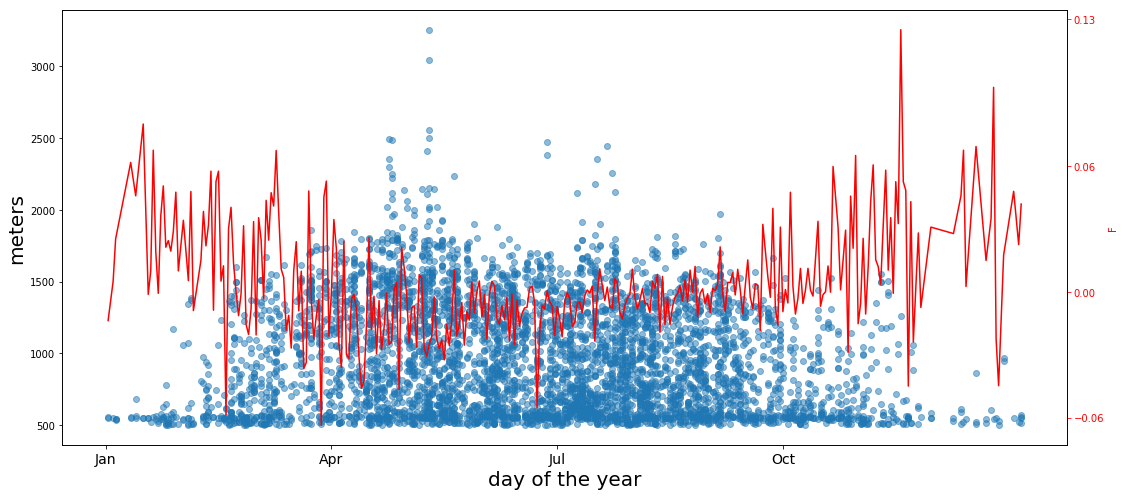

In [761]:
dates = matplotlib.dates.date2num(data['date'])
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(data['doy_x'], data['max_alt'], alpha = 0.5,)
ax2 = ax.twinx()
ax2.plot(GP.index,GP['psgr_16'],color= 'r')
# ax.set_title('Maximum altutide [in meters, by doy]',fontsize=20)
ax.set_ylabel('meters', fontsize=20)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_yticks([-0.06,0,0.06,0.13]) # choose which x locations to have ticks
# ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_ylabel('F', color='r')
ax2.tick_params('y', colors='r')
ax.set_xlabel('day of the year', fontsize=20)


In [762]:
data = data.sort_values('date',axis=0)
data.reset_index(inplace=True,drop=True)


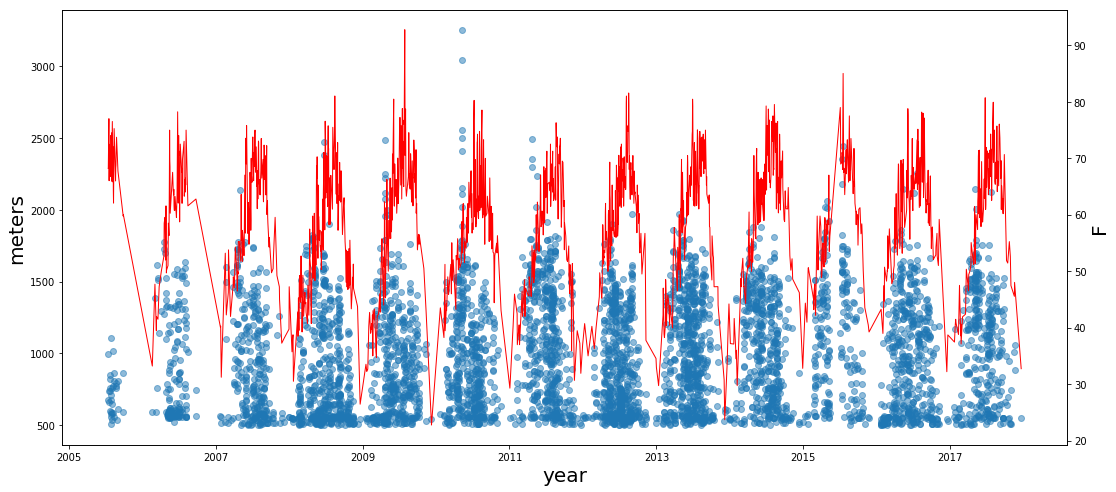

In [763]:
dates = matplotlib.dates.date2num(data['date'])
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(dates, data['max_alt'],'o' ,alpha = 0.5,)
ax2 = ax.twinx()
ax2.plot(dates,data['tmpf_16'],color = 'r',linewidth=1)
# ax.set_title('Maximum altutide [in meters, by doy]',fontsize=20)
ax.set_ylabel('meters', fontsize=20)
# ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
# ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
# ax2.set_yticks([45,60,75,90]) # choose which x locations to have ticks
# ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_ylabel('F',fontsize=20)
# ax2.tick_params('y')
ax.set_xlabel('year', fontsize=20)
# plt.savefig('flight_temp.png')
ax2.autoscale()
ax.autoscale()
ax.xaxis_date()




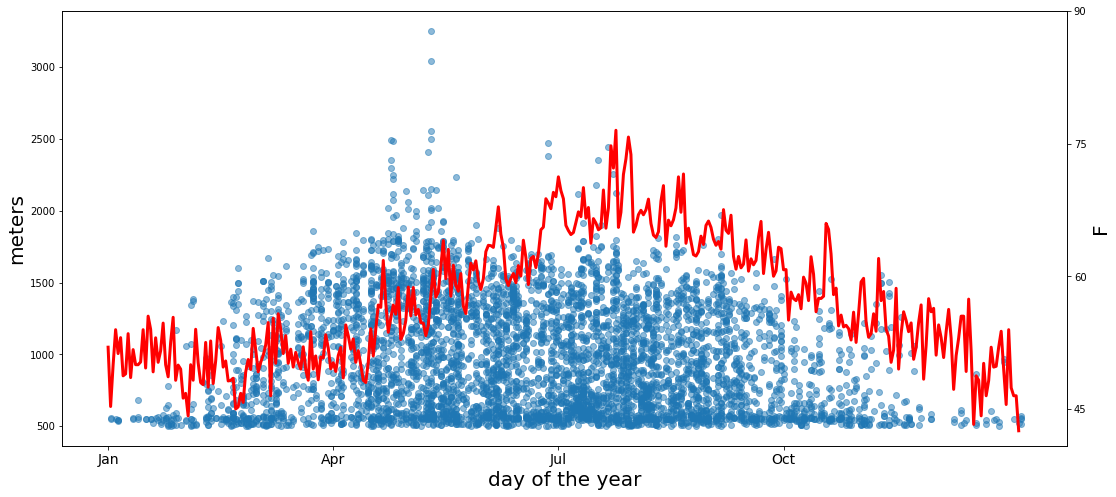

In [764]:
dates = matplotlib.dates.date2num(data['date'])
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(data['doy_x'], data['max_alt'], alpha = 0.5,)
ax2 = ax.twinx()
ax2.plot(avg_temp.index,avg_temp,color = 'r',linewidth=3)
# ax.set_title('Maximum altutide [in meters, by doy]',fontsize=20)
ax.set_ylabel('meters', fontsize=20)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_yticks([45,60,75,90]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_ylabel('F',fontsize=20)
ax2.tick_params('y')
ax.set_xlabel('day of the year', fontsize=20)
plt.savefig('flight_temp.png')

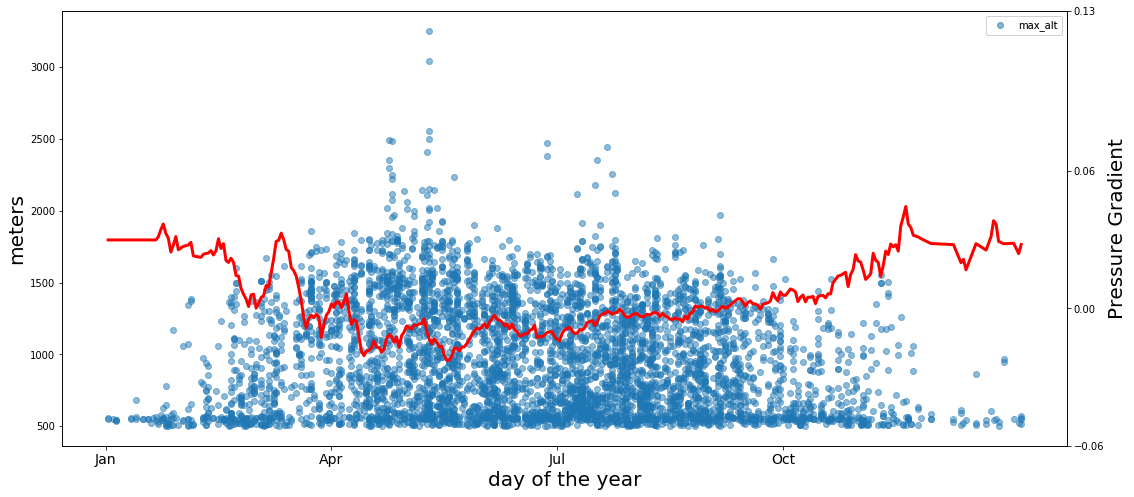

In [765]:
dates = matplotlib.dates.date2num(data['date'])
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(data['doy_x'], data['max_alt'], alpha = 0.5,)

# ax2.plot(GP.index,GP['psgr_16'],color= 'r')
ax2 = ax.twinx()
ax2.plot(GP.index,moving_average(GP['psgr_16'].as_matrix(),n=10),color= 'r',linewidth=3)
ax.set_ylabel('meters', fontsize=20)
ax.set_xlabel('day of the year', fontsize=20)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_yticks([-0.06,0,0.06,0.13]) # choose which x locations to have ticks
# ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax2.set_ylabel('Pressure Gradient', fontsize=20)
ax2.tick_params('y')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
ax2.legend(loc=0)
plt.show()
plt.savefig('flight_press.png')

In [766]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    output = ret[n - 1:] / n
    output = np.insert(output,0,np.array([output[0]]*(n-1)))
    return output
    

In [767]:
data.columns

Index(['flight', 'date', 'pilot', 'launch_time', 'landing_time', 'flying_time',
       'launch_coord', 'landing_coord', 'landed_lz', 'linear_dist', 'max_alt',
       'total_alt_gain', 'left_perimeter', 'month', 'year', 'timestamp',
       'doy_x', 'rank_alt_0', 'rank_alt_1', 'rank_alt_2', 'overall_rank_0',
       'overall_rank_1', 'overall_rank_2', 'pilot_rank_0', 'pilot_rank_1',
       'pilot_rank_2', 'alti_0', 'alti_4', 'alti_8', 'alti_12', 'alti_16',
       'alti_20', 'drct_0', 'drct_4', 'drct_8', 'drct_12', 'drct_16',
       'drct_20', 'dwpf_0', 'dwpf_4', 'dwpf_8', 'dwpf_12', 'dwpf_16',
       'dwpf_20', 'p01i_0', 'p01i_4', 'p01i_8', 'p01i_12', 'p01i_16',
       'p01i_20', 'relh_0', 'relh_4', 'relh_8', 'relh_12', 'relh_16',
       'relh_20', 'sknt_0', 'sknt_4', 'sknt_8', 'sknt_12', 'sknt_16',
       'sknt_20', 'skyc1_0', 'skyc1_4', 'skyc1_8', 'skyc1_12', 'skyc1_16',
       'skyc1_20', 'psgr_0', 'psgr_4', 'psgr_8', 'psgr_12', 'psgr_16',
       'psgr_20', 'tmpf_0', 'tmpf_4', 'tmpf_8'

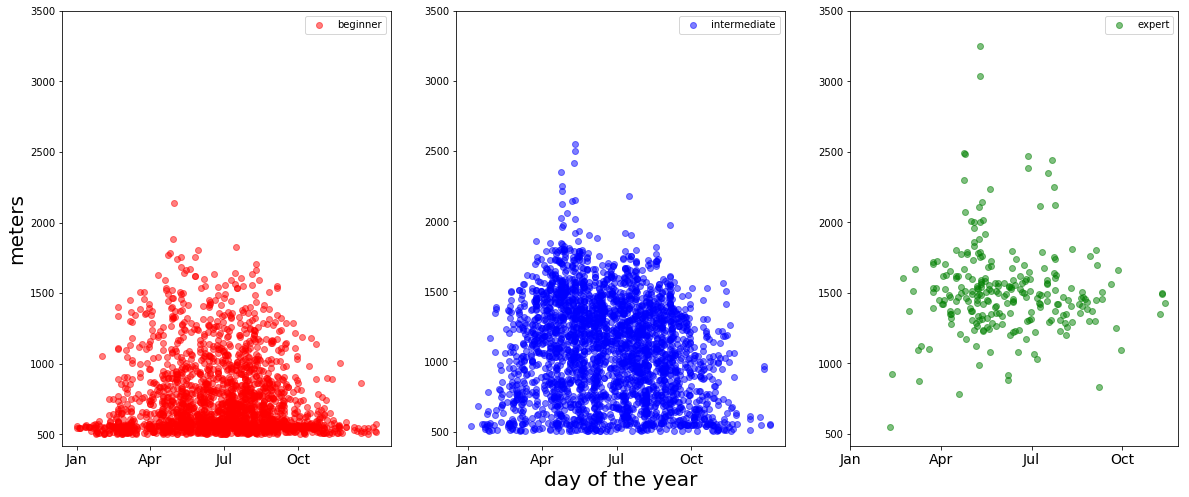

In [768]:
dates = matplotlib.dates.date2num(data['date'])
fig,ax = plt.subplots(1,3,figsize = (20,8))

ax[0].scatter(data['doy_x'][data['rank_alt_0']==1], data['max_alt'][data['rank_alt_0']==1], alpha = 0.5,color = 'r',label='beginner')
# ax[0].set_xlabel('day of the year', fontsize=20)
ax[0].set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax[0].set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax[0].set_yticks([500,1000,1500,2000,2500,3000,3500]) # choose which x locations to have ticks
ax[0].set_ylabel('meters', fontsize=20)

ax[1].scatter(data['doy_x'][data['rank_alt_1']==1], data['max_alt'][data['rank_alt_1']==1], alpha = 0.5,color = 'b',label='intermediate')
ax[1].set_yticks([500,1000,1500,2000,2500,3000,3500]) # choose which x locations to have ticks
ax[1].set_xlabel('day of the year', fontsize=20)
ax[1].set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax[1].set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)


ax[2].scatter(data['doy_x'][data['rank_alt_2']==1], data['max_alt'][data['rank_alt_2']==1], alpha = 0.5,color = 'g',label='expert')
ax[2].set_yticks([500,1000,1500,2000,2500,3000,3500]) # choose which x locations to have ticks
# ax[2].set_xlabel('day of the year', fontsize=20)
ax[2].set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax[2].set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax[2].set_yticks([500,1000,1500,2000,2500,3000,3500]) # choose which x locations to have ticks




handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels)
ax[1].legend()
ax[2].legend()

plt.show()

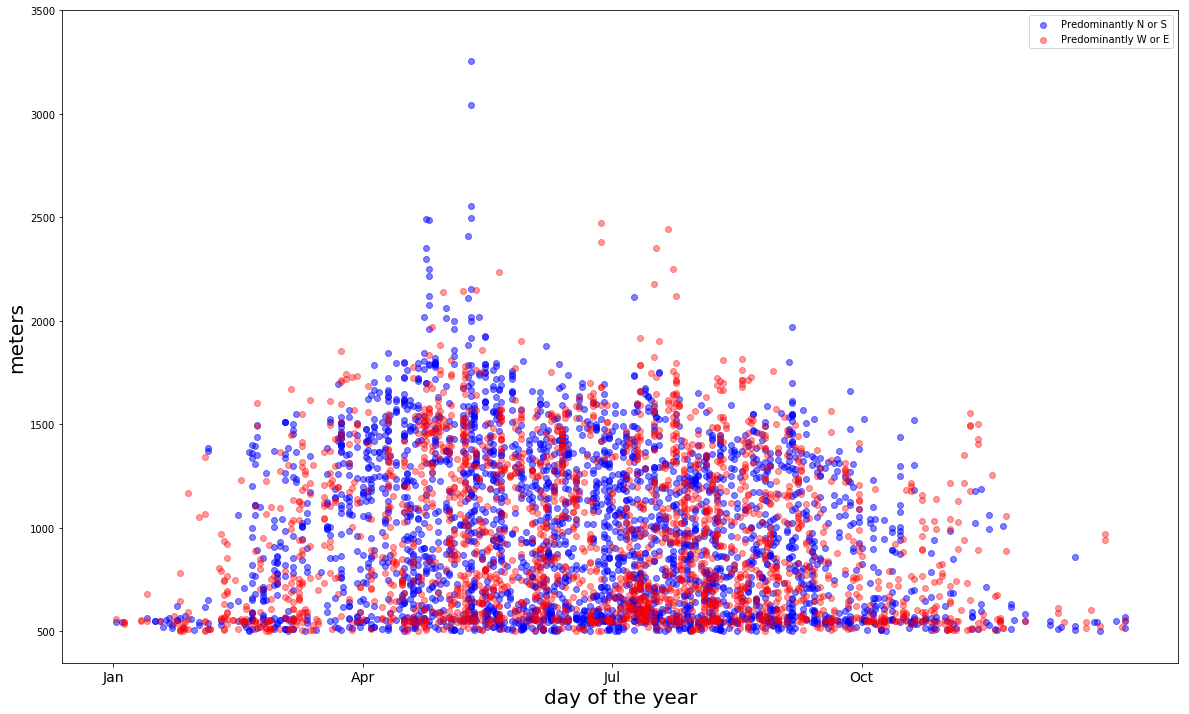

In [784]:
dates = matplotlib.dates.date2num(data['date'])
fig,ax = plt.subplots(figsize = (20,12))

cut = cos(radians(45))**2
ax.scatter(data['doy_x'][data['drct_16']>=cut], data['max_alt'][data['drct_16']>=cut], alpha = 0.5,color = 'b',label='Predominantly N or S')
ax.scatter(data['doy_x'][data['drct_16']<cut], data['max_alt'][data['drct_16']<cut], alpha = 0.4,color = 'r',label='Predominantly W or E')
# ax.scatter(data['doy_x'][data['rank_alt_2']==1], data['max_alt'][data['rank_alt_2']==1], alpha = 0.5,color = 'g',label='expert')

ax.set_yticks([500,1000,1500,2000,2500,3000,3500]) # choose which x locations to have ticks
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)
ax.set_ylabel('meters', fontsize=20)
ax.set_xlabel('day of the year', fontsize=20)



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()